In [1]:
import os
import yaml
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from scipy.optimize import minimize
from pprint import pprint
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import math

print("Number of available GPUs: ", len(tf.config.list_physical_devices('GPU')))

# read configuration file
with open('config.yml', 'r') as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

2025-11-12 10:06:48.896386: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-12 10:06:48.949203: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-12 10:06:53.324495: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Number of available GPUs:  2


I0000 00:00:1762963620.845391 4183975 gpu_device.cc:2411] Ignoring visible gpu device (device: 2, name: NVIDIA T400 4GB, pci bus id: 0000:e3:00.0, compute capability: 7.5) with core count: 6. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.


In [2]:
def get_image_data(f):
    """
    Returns a tuple (Lens ID, image)
    """
    fits_data = fits.getdata(f, ext=0)
    return os.path.basename(f).split('.')[0][:-2], fits_data


def process_image(image):
    # normalize the image to the range [0, 1]
    image = (image - np.min(image)) / (np.max(image) - np.min(image))

    # apply gamma correction
    gamma = find_gamma(image, desired_median=0.2)
    return np.power(image, gamma)


def objective_function(gamma, image, desired_median):
    gamma_corrected_image = np.power(image, gamma)
    median_value = np.median(gamma_corrected_image)
    return (median_value - desired_median)**2


def find_gamma(image, desired_median=0.2, initial_gamma=0.7):
    result = minimize(objective_function, initial_gamma, args=(image, desired_median), method='Nelder-Mead')
    return result.x[0]

Load the saved model

In [3]:
models = sorted(glob(os.path.join(config['data_dir'], 'models', '*.keras')))
pprint(models)

['/nfsdata1/bwedig/lsst-strong-lens-data-challenge/models/v1_ap99966643.keras',
 '/nfsdata1/bwedig/lsst-strong-lens-data-challenge/models/v2_ap99979441.keras',
 '/nfsdata1/bwedig/lsst-strong-lens-data-challenge/models/v3.keras',
 '/nfsdata1/bwedig/lsst-strong-lens-data-challenge/models/v4.keras',
 '/nfsdata1/bwedig/lsst-strong-lens-data-challenge/models/v5.keras']


In [4]:
model = keras.models.load_model(models[3])

I0000 00:00:1762963621.180741 4183975 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 16424 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:31:00.0, compute capability: 8.9
I0000 00:00:1762963621.182298 4183975 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46122 MB memory:  -> device: 1, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:b1:00.0, compute capability: 8.9


Take a quick look as the format that the submission CSV needs to have

In [5]:
example_csv = '/grad/bwedig/lsst-strong-lens-data-challenge/submission_format.csv'
example_df = pd.read_csv(example_csv)
print(example_df.head())

            id  preds   ra  dec  zlens  mag_lens_g  mag_lens_r  mag_lens_i  \
0  7.53391E+16      1 -999 -999   -999        -999        -999        -999   
1  7.46439E+16      0 -999 -999   -999        -999        -999        -999   
2  4.42233E+16      1 -999 -999   -999        -999        -999        -999   
3  6.95818E+16      0 -999 -999   -999        -999        -999        -999   
4  6.95997E+16      1 -999 -999   -999        -999        -999        -999   

   mag_lens_z  mag_lens_y  ...  n_l_sers  vel_disp   RA  Dec  mag_object_g  \
0        -999        -999  ...      -999      -999 -999 -999          -999   
1        -999        -999  ...      -999      -999 -999 -999          -999   
2        -999        -999  ...      -999      -999 -999 -999          -999   
3        -999        -999  ...      -999      -999 -999 -999          -999   
4        -999        -999  ...      -999      -999 -999 -999          -999   

   mag_object_r  mag_object_i  mag_object_z  mag_object_y  z_c

Create an empty version of this

In [6]:
df = example_df.iloc[0:0].copy()
print(df)

Empty DataFrame
Columns: [id, preds, ra, dec, zlens, mag_lens_g, mag_lens_r, mag_lens_i, mag_lens_z, mag_lens_y, ell_l, ell_l_PA, Rein, vel disp, sh, sh_PA, srcx, srcy, mag_src_g, mag_src_r, mag_src_i, mag_src_z, mag_src_y, zsrc, ell_s, ell_s_PA, Reff_s, n_s_sers, ell_m, ell_m_PA, Reff_l, n_l_sers, vel_disp, RA, Dec, mag_object_g, mag_object_r, mag_object_i, mag_object_z, mag_object_y, z_central]
Index: []

[0 rows x 41 columns]


In [7]:
# insert 'probs' column after 'preds' and before 'ra'
if 'probs' not in df.columns:
    # prefer an existing 'prob' column if present, otherwise create NaNs
    if 'prob' in df.columns:
        vals = df['prob'].astype(float)
    else:
        vals = pd.Series(np.nan, index=df.index, dtype=float)

    insert_at = list(df.columns).index('preds') + 1 if 'preds' in df.columns else 1
    df.insert(insert_at, 'probs', vals)

print("Columns after insert:", list(df.columns))

Columns after insert: ['id', 'preds', 'probs', 'ra', 'dec', 'zlens', 'mag_lens_g', 'mag_lens_r', 'mag_lens_i', 'mag_lens_z', 'mag_lens_y', 'ell_l', 'ell_l_PA', 'Rein', 'vel disp', 'sh', 'sh_PA', 'srcx', 'srcy', 'mag_src_g', 'mag_src_r', 'mag_src_i', 'mag_src_z', 'mag_src_y', 'zsrc', 'ell_s', 'ell_s_PA', 'Reff_s', 'n_s_sers', 'ell_m', 'ell_m_PA', 'Reff_l', 'n_l_sers', 'vel_disp', 'RA', 'Dec', 'mag_object_g', 'mag_object_r', 'mag_object_i', 'mag_object_z', 'mag_object_y', 'z_central']


Load the `.fits` files, making sure to stack them correctly

In [8]:
data_dir = '/data/bwedig/lsst-strong-lens-data-challenge/test_dataset_updated'

fits_files = sorted(glob(os.path.join(data_dir, '*.fits')))
print(f"Found {len(fits_files)} FITS files.")

unique_ids = set([os.path.basename(f).split('.')[0][:-2] for f in fits_files])
print(f"Found {len(unique_ids)} unique IDs.")

Found 500000 FITS files.
Found 100000 unique IDs.


  0%|          | 0/1563 [00:00<?, ?it/s]

2025-11-12 10:07:05.528603: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f55440183e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-12 10:07:05.528622: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2025-11-12 10:07:05.528625: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (1): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2025-11-12 10:07:05.539892: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-12 10:07:05.638589: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91301
2025-11-12 10:07:06.442552: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warm

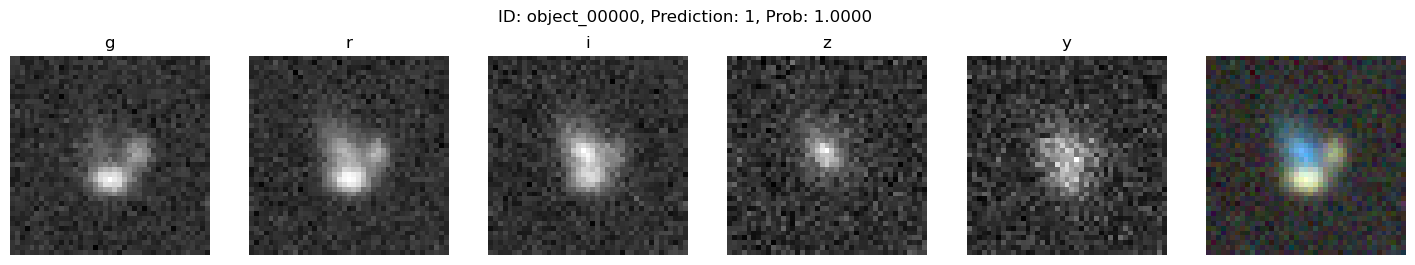

  4%|▍         | 63/1563 [00:55<19:55,  1.25it/s] /tmp/ipykernel_4183975/660805427.py:19: RuntimeWarning: divide by zero encountered in power
  gamma_corrected_image = np.power(image, gamma)
  8%|▊         | 125/1563 [01:45<19:09,  1.25it/s]

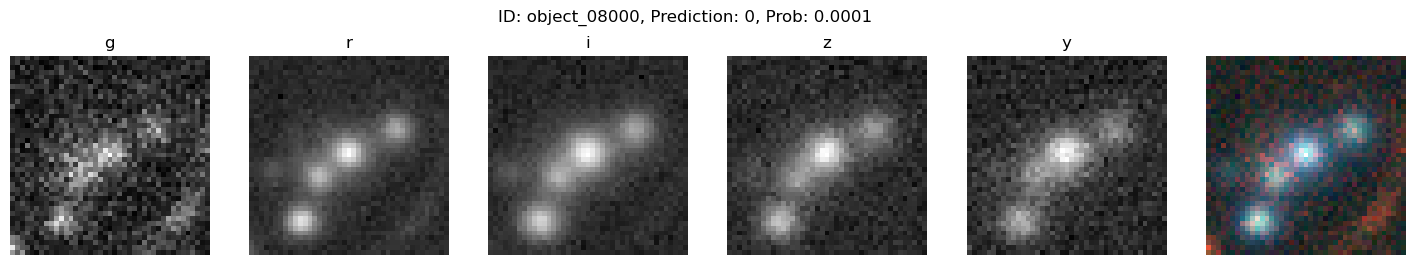

 16%|█▌        | 250/1563 [03:28<17:28,  1.25it/s]

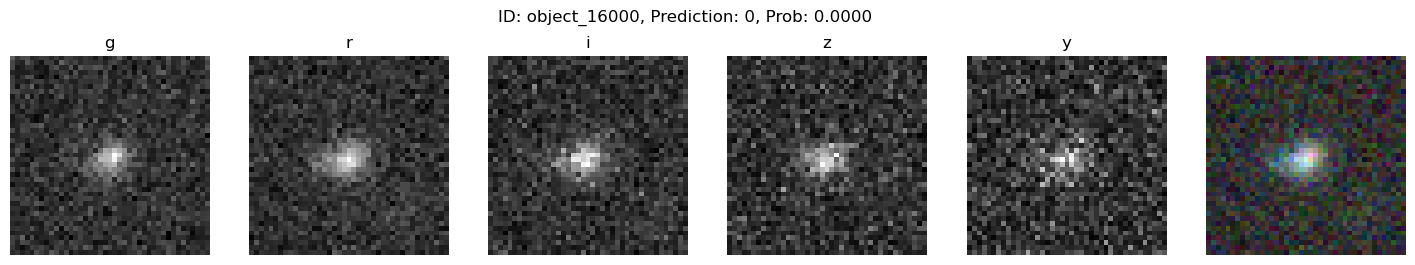

 24%|██▍       | 375/1563 [05:14<38:37,  1.95s/it]

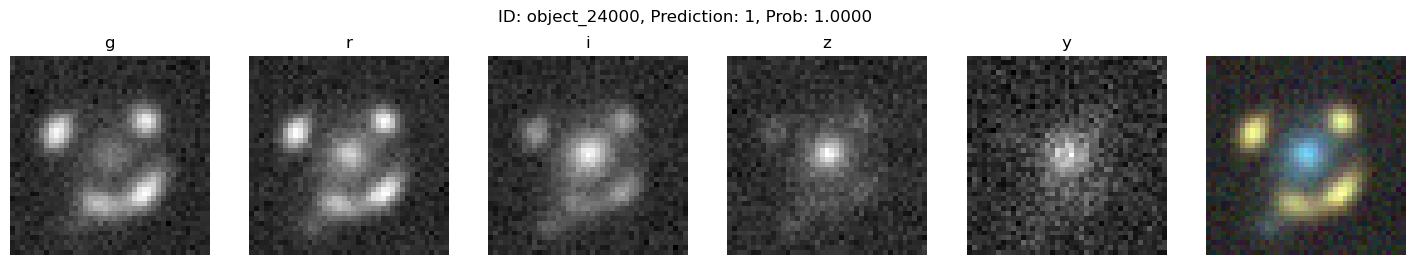

 32%|███▏      | 500/1563 [06:54<14:12,  1.25it/s]

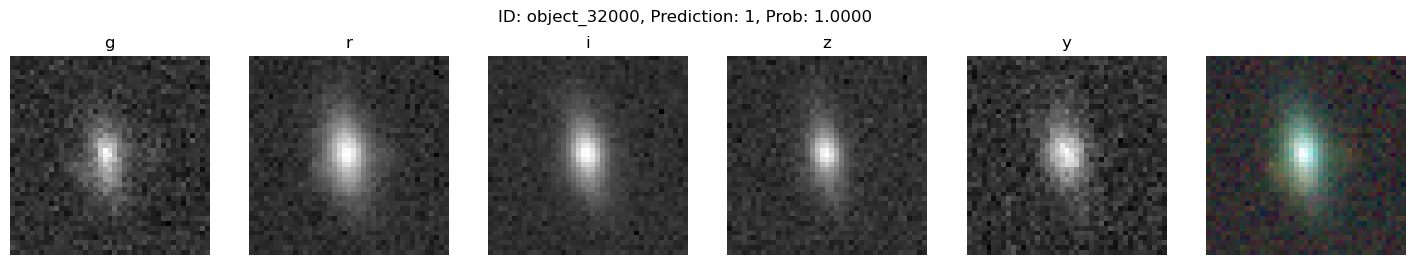

 40%|███▉      | 625/1563 [08:35<12:45,  1.22it/s]

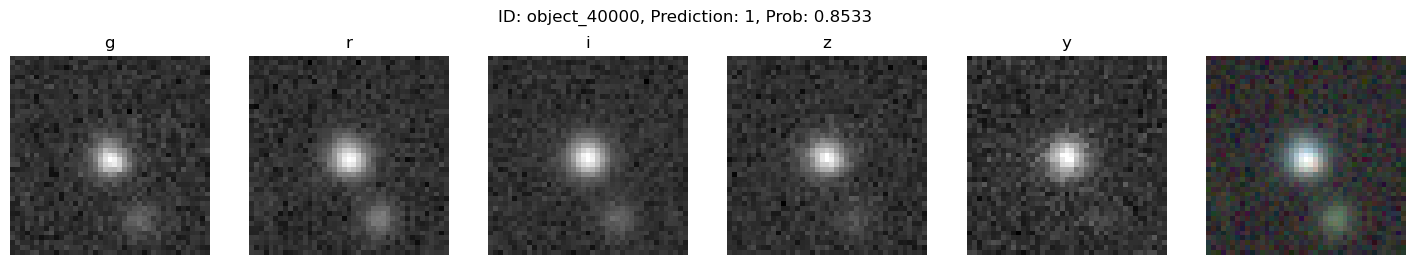

 48%|████▊     | 750/1563 [10:21<13:21,  1.01it/s]

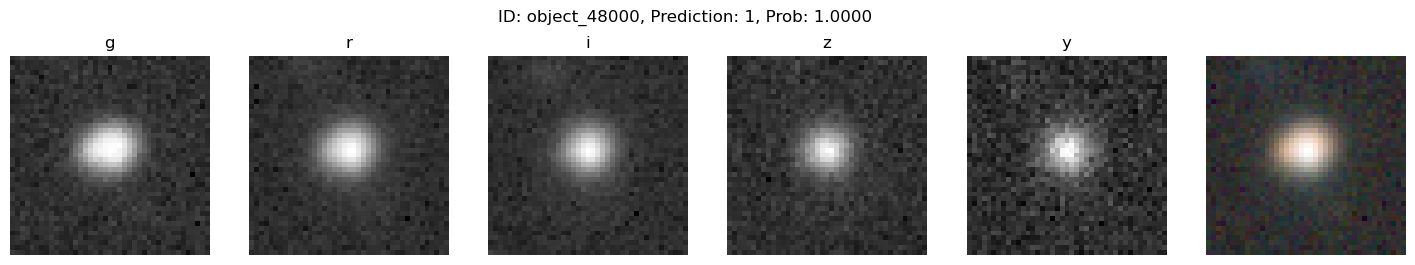

 56%|█████▌    | 875/1563 [12:01<09:05,  1.26it/s]

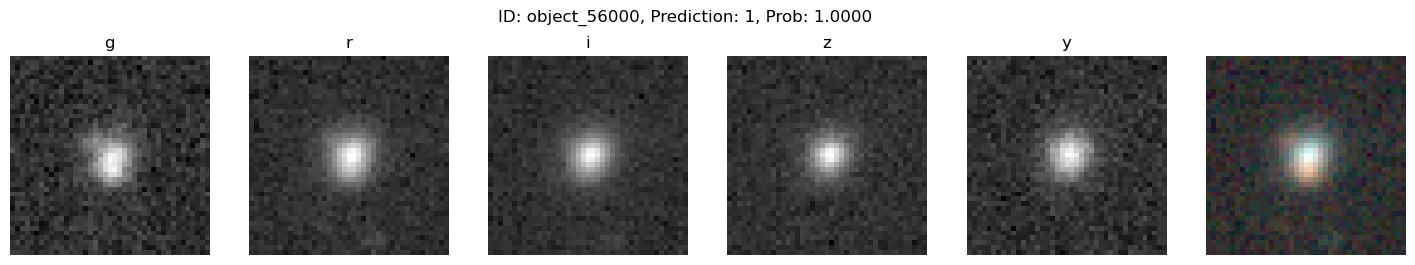

 64%|██████▍   | 1000/1563 [13:42<07:28,  1.26it/s]

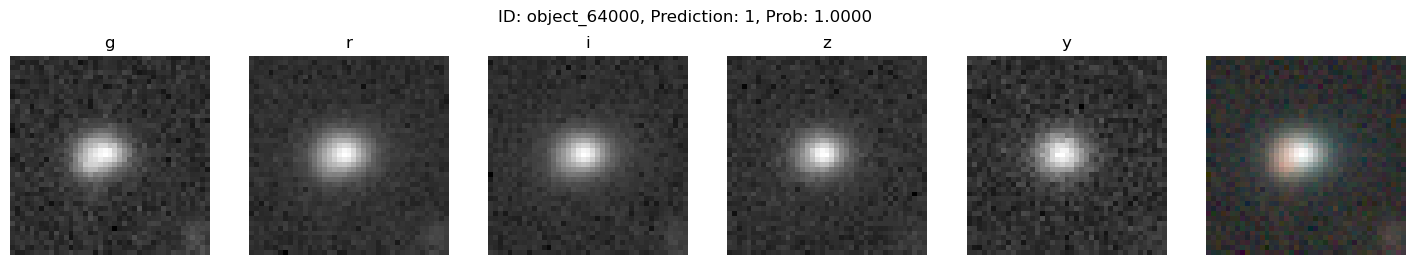

 72%|███████▏  | 1125/1563 [15:29<05:52,  1.24it/s]

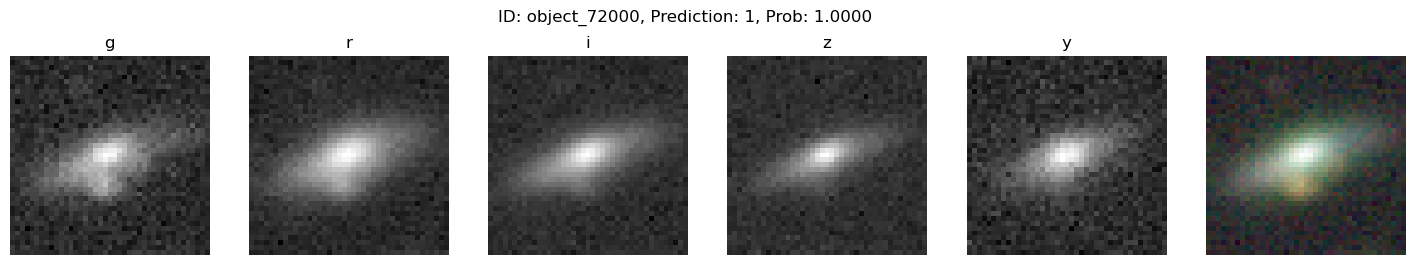

 80%|███████▉  | 1250/1563 [17:10<04:36,  1.13it/s]

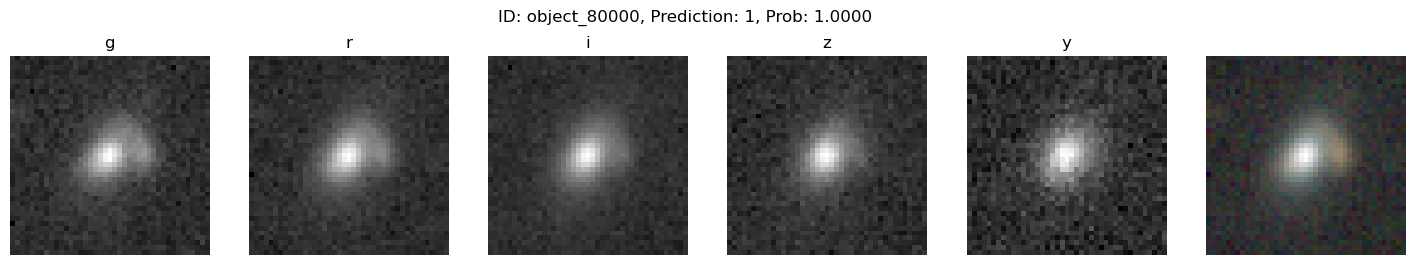

 88%|████████▊ | 1375/1563 [18:50<02:29,  1.26it/s]

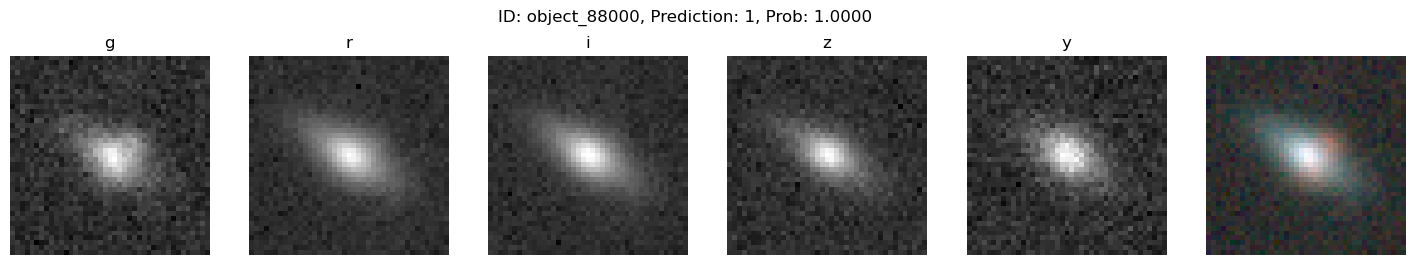

 96%|█████████▌| 1500/1563 [20:36<00:49,  1.28it/s]

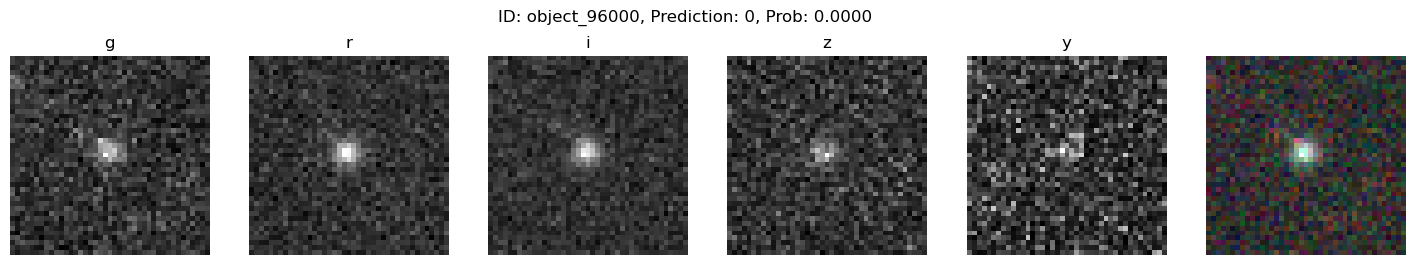

100%|██████████| 1563/1563 [21:26<00:00,  1.21it/s]


In [9]:
bands = ['g', 'r', 'i', 'z', 'y']

os.nice(19)

# speed params
batch_size = 64           # increase to use more memory but fewer model calls
max_workers = 8           # file read / preprocessing workers

ids_list = sorted(unique_ids)   # deterministic order
n_ids = len(ids_list)
rows = []

def load_and_preprocess(uid):
    images = []
    for band in bands:
        fp = os.path.join(data_dir, f'{uid}_{band}.fits')
        _, img = get_image_data(fp)
        # always run the full preprocessing (including gamma search)
        img = process_image(img)
        images.append(img)
    return np.stack(images, axis=-1)

for start in tqdm(range(0, n_ids, batch_size), total=math.ceil(n_ids / batch_size)):
    batch_uids = ids_list[start:start + batch_size]

    # parallel file read + preprocessing (preserves order with map)
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        stacks = list(ex.map(load_and_preprocess, batch_uids))

    X = np.stack(stacks, axis=0)  # (batch, H, W, channels)

    # single batched prediction
    preds_raw = model.predict(X, verbose=0)
    probs = tf.sigmoid(preds_raw).numpy().ravel()
    preds_bin = (probs > 0.5).astype(int)

    # collect rows, avoid pd.concat in the inner loop
    for uid, p, prob in zip(batch_uids, preds_bin, probs):
        rows.append({'id': uid, 'preds': int(p), 'probs': float(prob)})

    # optional sanity plot (only a few times)
    if start % 1000 == 0:
        sample_stack = stacks[0]
        sample_pred = int(preds_bin[0])
        f, ax = plt.subplots(1, 6, figsize=(18, 3))
        for j, band in enumerate(bands):
            ax[j].imshow(sample_stack[:, :, j], cmap='gray')
            ax[j].set_title(band)
            ax[j].axis('off')
        ax[5].imshow(sample_stack[:, :, :3])
        ax[5].axis('off')
        plt.suptitle(f"ID: {batch_uids[0]}, Prediction: {sample_pred}, Prob: {probs[0]:.4f}")  # 
        plt.show()

# one final concat (fast)
new_df = pd.DataFrame(rows, columns=['id', 'preds', 'probs'])
df = pd.concat([df, new_df], ignore_index=True)

In [10]:
df

,id,preds,probs,ra,dec,zlens,mag_lens_g,mag_lens_r,mag_lens_i,mag_lens_z,...,n_l_sers,vel_disp,RA,Dec,mag_object_g,mag_object_r,mag_object_i,mag_object_z,mag_object_y,z_central
0,object_00000,1,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,object_00001,1,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,object_00002,0,3.027005e-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,object_00003,0,2.166894e-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,object_00004,1,9.999999e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,object_99995,0,1.631679e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99996,object_99996,1,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99997,object_99997,0,8.269174e-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99998,object_99998,1,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df = df.fillna(-999)
df

,id,preds,probs,ra,dec,zlens,mag_lens_g,mag_lens_r,mag_lens_i,mag_lens_z,...,n_l_sers,vel_disp,RA,Dec,mag_object_g,mag_object_r,mag_object_i,mag_object_z,mag_object_y,z_central
0,object_00000,1,1.000000e+00,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,object_00001,1,1.000000e+00,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
2,object_00002,0,3.027005e-09,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
3,object_00003,0,2.166894e-18,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
4,object_00004,1,9.999999e-01,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,object_99995,0,1.631679e-07,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
99996,object_99996,1,1.000000e+00,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
99997,object_99997,0,8.269174e-13,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
99998,object_99998,1,1.000000e+00,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0


In [12]:
# keep only 'id' and 'preds' columns (if present)
keep = [c for c in ['id', 'preds', 'probs'] if c in df.columns]
df = df[keep].copy()
print(f"Kept columns: {keep}")
df.head()

Kept columns: ['id', 'preds', 'probs']


,id,preds,probs
0,object_00000,1,1.000000e+00
1,object_00001,1,1.000000e+00
2,object_00002,0,3.027005e-09
3,object_00003,0,2.166894e-18
4,object_00004,1,9.999999e-01


In [13]:
out_path = '/data/bwedig/lsst-strong-lens-data-challenge/v4_submission_with_probs.csv'
if os.path.exists(out_path):
    os.remove(out_path)
df.to_csv(out_path, index=False)
print(f"Wrote {out_path}")

Wrote /data/bwedig/lsst-strong-lens-data-challenge/v4_submission_with_probs.csv
